# South African Language Identification Hack 2022

In this challenge, i will build a Machine learning classification model that takes text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in.

# 1 Import Libraries

In [69]:
! pip install WordCloud
! pip install advertools
! pip install comet_ml
! nltk.download(['punkt','stopwords'])

ERROR: Could not find a version that satisfies the requirement WordCloud (from versions: none)
ERROR: No matching distribution found for WordCloud


'nltk.download' is not recognized as an internal or external command,
operable program or batch file.


In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import  mean
from sklearn.ensemble import BaggingClassifier

import warnings
warnings.filterwarnings('ignore')


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# 2 Loading Data

In [71]:
df_train_set = pd.read_csv('train_set.csv')
df_test_set = pd.read_csv('test_set.csv')

Have a look at the data format inside the pandas data frames

In [72]:
df_train_set.head(3)

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...


In [73]:
df_test_set.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


Observations:

The data is not clean enough to build a good machine leaning model.  I am going  to clean it a bit, well what is data cleaning?, we are going to explore this concept in the next few cells.

# 3 Data cleaning

Data cleaning is the process of preparing data for analysis by removing or modifying data that is incorrect, incomplete, irrelevant, duplicated, or improperly formatted.If data is not cleaned thoroughly, the accuracy of the model stands on shakey grounds.

It involves:

- Removing unuseful information in this case:
   > Punctuation Marks

   > Removing all remaining whitespaces

   > removing numbers 
   
- Coverting into a uniform text format: eg all words to lower case
- Identifying duplicate data and droping them

In [74]:
def clean_data(text_data): 
    text_data= re.sub("[^a-zA-Z0-9 ]", "", text_data) #Extracting Remaining text from  
    text_data = re.sub(r'[,!?;-]+', '.', text_data) #Removing any remaining non-characters
    text_data = text_data.replace('[^a-zA-Z#]','')
    text_data = text_data.lower() # Change words to lower case
    text_data= text_data.lstrip('\'"') # Remove extra white space
    return text_data

In [75]:
df_train_set['cleaned_text'] = df_train_set['text'].apply(clean_data)
df_test_set['cleaned_text'] = df_test_set['text'].apply(clean_data)

In [76]:
# remove numbers 
df_train_set['cleaned_text'] = df_train_set['cleaned_text'].str.replace('\d+', '')
df_test_set['cleaned_text'] = df_test_set['cleaned_text'].str.replace('\d+', '')

In [77]:
df_train_set.head(3)

,lang_id,text,cleaned_text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,umgaqosiseko wenza amalungiselelo kumaziko axh...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,idha iya kuba nobulumko bokubeka umsebenzi nap...
2,eng,the province of kwazulu-natal department of tr...,the province of kwazulunatal department of tra...


In [78]:
df_test_set.head(3)

,index,text,cleaned_text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele...",mmasepala fa maemo a a kgethegileng a letlelel...
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.,tshivhumbeo tshi fana na ngano dza vhathu


# 4 Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an approach to analyze the data using visual techniques. It is used to discover trends,to perform preliminary investigations on data in order to uncover patterns, detect anomalies, test hypotheses, and verify assumptions.

Text(0.5, 1.0, 'Class Distributions')

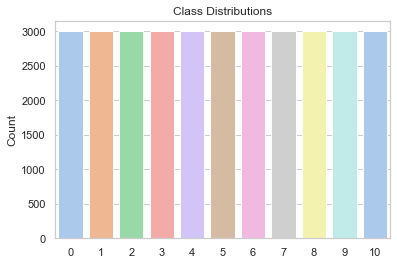

In [79]:
#lets explore the language distribution 

language_distr = pd.DataFrame(list(df_train_set['lang_id'].value_counts()),columns=['Count'])

# Plot class distribution
sns.set(style="whitegrid")
sns.barplot( x =language_distr.index, y= language_distr.Count, 
           palette="pastel")
plt.title('Class Distributions')
#palette="Blues_d")

Observations:

From the dar graph above we can see that all the data is equally distributed 

### Duplicates 

Duplicated data is the data that appears more than once in the rows
 
Lets investigate if we have any duplicate data in our data set

In [80]:
# Look atr the dimension of train set
df_train_set.shape

(33000, 3)

In [81]:
# function to drop duplicates if any 
df_train_set.drop_duplicates(keep=False, inplace=True)
df_test_set.drop_duplicates(keep=False, inplace=True)

Text(0.5, 0, 'Language id ')

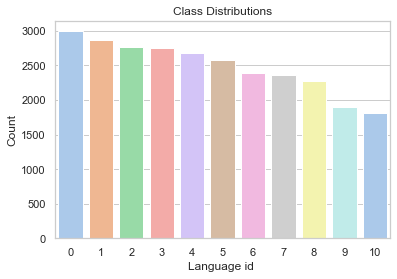

In [82]:
# Lets plot the bar graph to check if we still have duplicates
#lets explore the language distribution 

language_distr = pd.DataFrame(list(df_train_set['lang_id'].value_counts()),columns=['Count'])

# Plot class distribution
sns.set(style="whitegrid")
sns.barplot( x =language_distr.index, y= language_distr.Count, 
           palette="pastel")
plt.title('Class Distributions')
plt.xlabel('Language id ')
#palette="Blues_d")

Observations :

We can see that the bar graph slightly changed , meaning our data contained duplicates 

### Check all the languanges available on our data set

In [83]:
languages = list(df_train_set.lang_id.unique())
print(languages)

['xho', 'eng', 'nso', 'ven', 'tsn', 'ssw', 'zul', 'tso', 'sot', 'nbl', 'afr']


language distribution per row

In [84]:
lang_distr = pd.DataFrame(list(df_train_set['lang_id'].value_counts()),columns=['Count'])
lang_distr

,Count
0,2996
1,2863
2,2769
3,2760
4,2683
5,2577
6,2397
7,2364
8,2276
9,1906


Observations:

We can see the numbers of rows available in our dataset in each language

In [85]:
# Create tweet features to explore tweet lengths
df_train_set['no_of_characters'] = df_train_set['cleaned_text'].apply(len)
df_train_set['word_count'] = df_train_set.cleaned_text.str.split().apply(len)
df_train_set['av_word_length'] = df_train_set['no_of_characters']/df_train_set['word_count']

df_test_set['no_of_characters'] = df_test_set['cleaned_text'].apply(len)
df_test_set['word_count'] = df_test_set.cleaned_text.str.split().apply(len)
df_test_set['av_word_length'] = df_test_set['no_of_characters']/df_test_set['word_count']

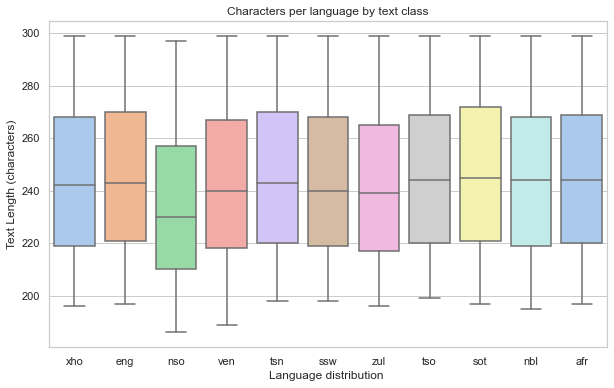

In [86]:
# create boxplot of characters per language class
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_train_set['lang_id'],
            y=df_train_set['no_of_characters'],
            data=df_train_set,
            palette="pastel")

plt.title('Characters per language by text class')
plt.xlabel('Language distribution ')
plt.ylabel('Text Length (characters)');

### Tokenisation

Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units are called tokens.Tokenisation is important because the meaning of the text could easily be interpreted by analyzing the words present in the text.

Here we are going to tokenize our text

In [87]:
# Creating token for the clean language
df_train_set['text_tokens'] = df_train_set['cleaned_text'].apply(lambda x: word_tokenize(x))
df_test_set['text_tokens'] = df_test_set['cleaned_text'].apply(lambda x: word_tokenize(x))

In [88]:
df_train_set.head(2)

,lang_id,text,cleaned_text,no_of_characters,word_count,av_word_length,text_tokens
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,idha iya kuba nobulumko bokubeka umsebenzi nap...,250,31,8.064516,"[idha, iya, kuba, nobulumko, bokubeka, umseben..."
2,eng,the province of kwazulu-natal department of tr...,the province of kwazulunatal department of tra...,263,37,7.108108,"[the, province, of, kwazulunatal, department, ..."


###  Lammatization

Lemmatizing is the process of grouping words of similar meaning together. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma (Manning et al., 2018). (e.g. “better” is lemmatized as “good”)## Lemmatization

In [89]:
lemmatizer = WordNetLemmatizer()
def text_lamma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]

In [90]:

df_train_set['lem_text'] = df_train_set['text_tokens'].apply(text_lamma, args=(lemmatizer, ))
df_test_set['lem_text'] = df_test_set['text_tokens'].apply(text_lamma, args=(lemmatizer, ))

In [91]:
df_train_set.head(2)

,lang_id,text,cleaned_text,no_of_characters,word_count,av_word_length,text_tokens,lem_text
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,idha iya kuba nobulumko bokubeka umsebenzi nap...,250,31,8.064516,"[idha, iya, kuba, nobulumko, bokubeka, umseben...","[idha, iya, kuba, nobulumko, bokubeka, umseben..."
2,eng,the province of kwazulu-natal department of tr...,the province of kwazulunatal department of tra...,263,37,7.108108,"[the, province, of, kwazulunatal, department, ...","[the, province, of, kwazulunatal, department, ..."


# 5 Feature extraction
Vactorization
Vectorization is jargon for a classic approach of converting input data from its raw format (i.e. text ) into vectors of real numbers which is the format that ML models support

vectorization is a step in feature extraction. The idea is to get some distinct features out of the text for the model to train on, by converting text to numerical vectors

There are many vactorisation methods but here we are going to use the Term Frequency-Inverse Document Frequency (TF-IDF)

#### Term Frequency-Inverse Document Frequency (TF-IDF)
Term Frequency-Inverse Document Frequency is an advanced algorithm that calculates the weight (or importance) of a word across a corpus of documents that are relevant to that given word. As it relates to search, engines will score a term based on how often that term appears versus how often other words appear with that word. It will then rank it against the other terms that frequently appear across those pages. The higher the TF-IDF score the rarer the word.

Term Frequency: How often the word appears in the document
Inverse Document Frequency: Weighing words that appear more frequently (such as and, the, or which are stop words are typically disregarded) and prioritizing unique words that appear commonly across documents.

In [92]:
X= df_train_set['cleaned_text']
X_val =df_test_set['cleaned_text']
y = df_train_set['lang_id']

In the above cell data was split into X and Y

In [93]:
vectorizer = TfidfVectorizer(sublinear_tf=True)
X = vectorizer.fit_transform(X)
X_val = vectorizer.transform(X_val)

Use the train test split and allocate the data test size to be 20 percent of the data 

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 42)

Creating a baseline prediction to be used to access model performance

In [95]:

acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.11


### Training model using Naive bayes classifier

In [96]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred=nb_model.predict(X_test)
print(f'Training perfomance = {nb_model.score(X_train, y_train) }')
print(f'Testing perfomance = {nb_model.score(X_test, y_test) }')

Training perfomance = 0.9991788321167884
Testing perfomance = 0.9925196132092684


### Logistic regression model for training

In [97]:
log_model = LogisticRegression(multi_class='ovr', solver='liblinear')
log_model.fit(X_train, y_train)

print(f'Training performance = {log_model.score(X_train, y_train)}')
print(f'Testing performance = {log_model.score(X_test,y_test) }')

Training performance = 0.9989051094890511
Testing performance = 0.9923371647509579


### Random forest model for model training

In [98]:
rf_model = RandomForestClassifier(min_samples_leaf = 2,n_estimators=400)
rf_model.fit(X_train,y_train)

print(f'Training performance = {rf_model.score(X_train, y_train) }')
print(f'Testing performance = {rf_model.score(X_test, y_test) }')

Training performance = 0.9918795620437956
Testing performance = 0.9854041233351578


### Best model

In [112]:
prediction = log_model.predict(X_val)

In [113]:
prediction[:10]

array(['tsn', 'nbl', 'ven', 'ssw', 'xho', 'nso', 'xho', 'sot', 'zul',
       'eng'], dtype=object)

In [114]:
df_test_set['lang_id'] = prediction

In [115]:
df_test_set.rename(columns={'pred':'lang_id'},inplace=True)

In [116]:
submission = df_test_set[['index','lang_id']]

In [117]:
submission.head()

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,xho


In [118]:
submission = submission.set_index('lang_id')

In [119]:
submission.to_csv('submission.csv')